In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('/', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('/', download=True, train=False)

In [0]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [0]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

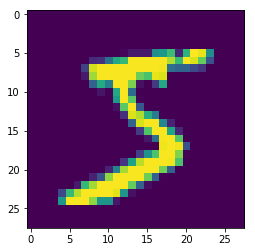

tensor(5)


In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

In [0]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super().__init__()
    self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
    self.act1 = torch.nn.LeakyReLU()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons*5)
    self.act2 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(n_hidden_neurons*5, n_hidden_neurons)
    self.act3 = torch.nn.Sigmoid()
    self.fc4 = torch.nn.Linear(n_hidden_neurons, 10)
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.fc4(x)
    return x

mnist_net = MNISTNet(50)

In [0]:
torch.cuda.is_available()

True

In [0]:
!nvidia-smi

Thu Sep 26 11:58:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    61W / 149W |  11433MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0002, -0.0095, -0.0115,  ...,  0.0018,  0.0187, -0.0318],
         [ 0.0034,  0.0025,  0.0278,  ...,  0.0282,  0.0256,  0.0175],
         [ 0.0033, -0.0187,  0.0128,  ..., -0.0224,  0.0089,  0.0118]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.1980e-02, -1.9162e-02, -3.3994e-02, -1.0583e-02,  2.5050e-02,
          1.0758e-02,  5.8520e-03, -3.1078e-02,  1.3870e-02,  3.2997e-02,
          7.2808e-03,  2.1296e-02,  1.9349e-02, -1.0779e-02, -2.4915e-02,
          2.5673e-02, -1.7654e-02, -2.2887e-02, -2.7681e-02, -1.1384e-02,
         -1.7487e-02,  1.1514e-02, -1.2511e-02,  3.5514e-02, -1.0688e-05,
          2.5205e-02, -6.4219e-03,  2.8707e-02, -4.7948e-03, -1.5754e-02,
         -2.1942e-02,  1

In [0]:
learning_rate = 0.001

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=learning_rate)

In [0]:
batch_size = 100

train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []


X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(40):
  order = np.random.permutation(len(X_train))
  
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()
    
    batch_indices = order[start_index: start_index+batch_size]
    
    X_batch = X_train[batch_indices].to(device)
    y_batch = y_train[batch_indices].to(device)
    
    y_pred = mnist_net.forward(X_batch)
    
    loss_value = loss(y_pred, y_batch)
    loss_value.backward()
    
    optimizer.step()
    
  train_preds = mnist_net.forward(X_batch)
  train_loss_history.append(loss(train_preds, y_batch))
  
  train_accuracy_history.append((train_preds.argmax(dim=1) == y_batch).float().mean())
    
  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test))
  
  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)
  
  print('accuracy:', accuracy, ', loss:', test_loss_history[epoch])

accuracy: tensor(0.9395, device='cuda:0') , loss: tensor(0.2262, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9505, device='cuda:0') , loss: tensor(0.1745, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9513, device='cuda:0') , loss: tensor(0.1579, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9574, device='cuda:0') , loss: tensor(0.1478, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9555, device='cuda:0') , loss: tensor(0.1521, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9569, device='cuda:0') , loss: tensor(0.1510, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9580, device='cuda:0') , loss: tensor(0.1433, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9588, device='cuda:0') , loss: tensor(0.1336, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9546, device='cuda:0') , loss: tensor(0.1526, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.

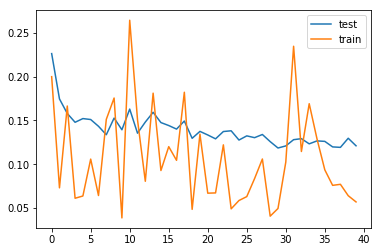

In [0]:
plt.plot(test_loss_history, label='test')
plt.plot(train_loss_history, label='train')
plt.legend()

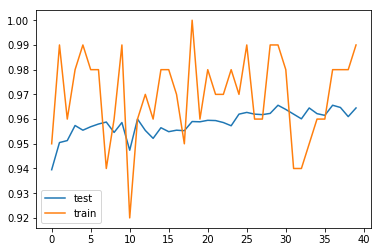

In [0]:
plt.plot(test_accuracy_history, label='test')
plt.plot(train_accuracy_history, label='train')
plt.legend()


In [0]:
batch_size = 100

train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []


X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
  order = np.random.permutation(len(X_train))
  
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()
    
    batch_indices = order[start_index: start_index+batch_size]
    
    X_batch = X_train[batch_indices].to(device)
    y_batch = y_train[batch_indices].to(device)
    
    y_pred = mnist_net.forward(X_batch)
    
    loss_value = loss(y_pred, y_batch)
    loss_value.backward()
    
    optimizer.step()
    
  train_preds = mnist_net.forward(X_batch)
  train_loss_history.append(loss(train_preds, y_batch))
  
  train_accuracy_history.append((train_preds.argmax(dim=1) == y_batch).float().mean())
    
  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test))
  
  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)
  
  print('accuracy:', accuracy, ', loss:', test_loss_history[epoch])

accuracy: tensor(0.9607, device='cuda:0') , loss: tensor(0.1352, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9636, device='cuda:0') , loss: tensor(0.1249, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9612, device='cuda:0') , loss: tensor(0.1289, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9609, device='cuda:0') , loss: tensor(0.1319, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9637, device='cuda:0') , loss: tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9576, device='cuda:0') , loss: tensor(0.1378, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9613, device='cuda:0') , loss: tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9588, device='cuda:0') , loss: tensor(0.1362, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.9621, device='cuda:0') , loss: tensor(0.1249, device='cuda:0', grad_fn=<NllLossBackward>)
accuracy: tensor(0.

tensor(0.1222, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0881, device='cuda:0', grad_fn=<DivBackward0>)


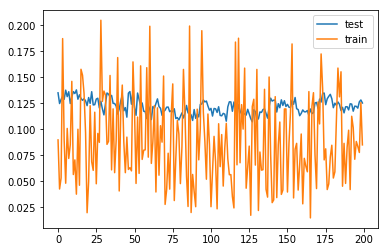

In [90]:
plt.plot(test_loss_history, label='test')
plt.plot(train_loss_history, label='train')
plt.legend()
print(sum(test_loss_history)/len(test_loss_history))
print(sum(train_loss_history)/len(train_loss_history))

tensor(0.9640, device='cuda:0')
tensor(0.9715, device='cuda:0')


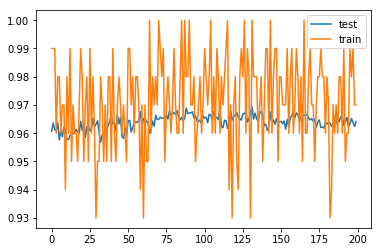

In [91]:
plt.plot(test_accuracy_history, label='test')
plt.plot(train_accuracy_history, label='train')
plt.legend()
print(sum(test_accuracy_history)/len(test_accuracy_history))
print(sum(train_accuracy_history)/len(train_accuracy_history))